<a href="https://colab.research.google.com/github/kwonzero/artists_classification/blob/main/kwonzero/cutmix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 베이스라인 + cutmix, cutoff
* Efficient-net B2
* result
    - train loss : 0.70887
    - validation loss : 0.75683
    - f1 score : 0.77528
    - epoch : 46

In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.7 MB/s eta 0:00:00


In [2]:
import gc
import random
from datetime import datetime

import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
CFG = {
    'IMG_SIZE': 384,
    'EPOCHS': 100,
    'LEARNING_RATE': 1e-3,
    'BATCH_SIZE': 16,
    'PATIENCE': 10,
    'SEED': 6
}

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

In [6]:
running_colab = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
if running_colab:
    data_path = '/content/drive/MyDrive/Project/CV/dataset/'
else:
    data_path = '../../data/'

Mounted at /content/drive


In [7]:
df = pd.read_csv(os.path.join(data_path, 'train.csv'))
df.loc[3896, 'artist'] = 'Titian'
df.loc[3986, 'artist'] = 'Alfred Sisley'
df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [8]:
artists = df.groupby('artist')[['id']].count().rename(columns={'id':'count'}).reset_index()

In [9]:
# Label Encoding
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df['artist'].values)

In [10]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=CFG['SEED'])

In [11]:
train_df = train_df.sort_values(by=['id'])
train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,9
1,1,./train/0001.jpg,48
3,3,./train/0003.jpg,10
4,4,./train/0004.jpg,24
6,6,./train/0006.jpg,43


In [12]:
val_df = val_df.sort_values(by=['id'])
val_df.head()

,id,img_path,artist
2,2,./train/0002.jpg,7
5,5,./train/0005.jpg,38
10,10,./train/0010.jpg,6
11,11,./train/0011.jpg,1
18,18,./train/0018.jpg,33


In [13]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values
    return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values, df['artist'].values

In [14]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [15]:
from torchvision.transforms import ToTensor


class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms if transforms else ToTensor()

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']

        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_paths)

In [16]:
train_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Transpose(p=0.5), # 행렬 스왑
    A.HorizontalFlip(p=0.5), # 좌우 반전
    A.VerticalFlip(p=0.5), # 상하 반전
    # A.ShiftScaleRotate(p=0.5), # 랜덤하게 옮기고, scale, 회전
    # A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5), # 빛깔, 색조, 값 변환
    # A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5), # 명도 대비
    # A.ChannelShuffle(), # RGB 채널 간 shuffle
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    # A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

In [17]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

In [18]:
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, worker_init_fn=seed_worker, generator=g, num_workers=4)

val_dataset = CustomDataset(val_img_paths, val_labels, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, worker_init_fn=seed_worker, generator=g, num_workers=4)

In [19]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = timm.create_model('efficientnet_b2', pretrained=True, num_classes=512)
        self.classifier = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [20]:
def clear_mem():
    gc.collect()
    torch.cuda.empty_cache()

## CutMix

In [21]:
def rand_bbox(size, lam):   # size : [B, C, W, H]
    W = size[2] # 이미지의 width
    H = size[3] # 이미지의 height
    cut_rat = np.sqrt(1. - lam)  # 패치 크기의 비율 정하기
    cut_w = np.int(W * cut_rat)  # 패치의 너비
    cut_h = np.int(H * cut_rat)  # 패치의 높이

    # uniform
    # 기존 이미지의 크기에서 랜덤하게 값을 가져옵니다.(중간 좌표 추출)
    cx = np.random.randint(W)
    cy = np.random.randint(H)

# 패치 부분에 대한 좌표값을 추출합니다.
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

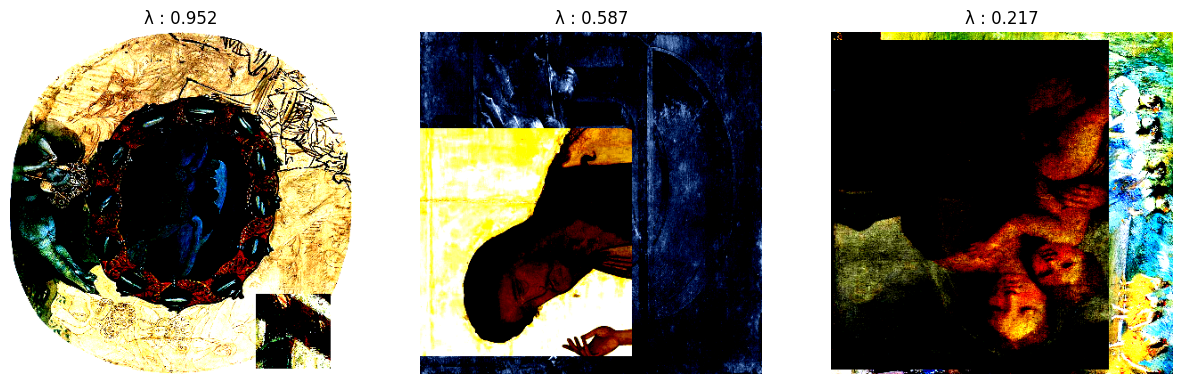

In [22]:
import matplotlib.pyplot as plt
def cutmix_plot(train_loader):
    fig , axes = plt.subplots(1,3)
    fig.set_size_inches(15,12)

    for i in range(3):
        for inputs, targets in train_loader:
            inputs = inputs
            targets = targets
            break

        lam = np.random.beta(1.0, 1.0)  # 베타 분포에서 lam 값을 가져옵나다.
        rand_index = torch.randperm(inputs.size()[0])   # batch_size 내의 인덱스가 랜덤하게 셔플됩니다.
        bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
        inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
        axes[i].imshow(inputs[1].permute(1, 2, 0).cpu())
        axes[i].set_title(f'λ : {np.round(lam,3)}')
        axes[i].axis('off')
    return

cutmix_plot(train_loader)

In [23]:
def train(model, optimizer, criterion, train_loader, device, beta=1, cutmix_prob=0.5):
    model.train()
    train_loss = []
    bar = tqdm(enumerate(train_loader), total = len(train_loader), desc='Train Loop')
    for idx, (img, label) in bar:
        img, label = img.float().to(device), label.long().to(device)

        optimizer.zero_grad()
        r = np.random.rand(1)
        if beta > 0 and r < cutmix_prob:
            lam = np.random.beta(beta, beta)
            rand_index = torch.randperm(img.size()[0]).cuda()
            target_a = label
            target_b = label[rand_index]
            bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
            img[:, :, bbx1:bbx2, bby1:bby2] = img[rand_index, :, bbx1:bbx2, bby1:bby2]

            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))

            model_pred = model(img)
            loss = criterion(model_pred, target_a) * lam + criterion(model_pred, target_b) * (1. - lam)
            loss.backward()
            optimizer.step()
        else:
            model_pred = model(img)
            loss = criterion(model_pred, label)
            loss.backward()
            optimizer.step()

        train_loss.append(loss.item())
        bar.set_postfix(train_loss = f'{loss.item():.4f}')
    return np.mean(train_loss)

In [24]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation(model, criterion, test_loader, device):
    model.eval()

    model_preds = []
    true_labels = []

    val_loss = []

    with torch.no_grad():
        for img, label in iter(test_loader):
            img, label = img.float().to(device), label.long().to(device)

            model_pred = model(img)

            loss = criterion(model_pred, label)

            val_loss.append(loss.item())

            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()

    val_f1 = competition_metric(true_labels, model_preds)
    return np.mean(val_loss), val_f1

In [25]:
time_now = datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M%S")
os.makedirs(os.path.join(data_path, f'./runs/{run_id}'), exist_ok=True)
print(f'{run_id=}')

run_id='20231214095042'


In [26]:
def train_epoch(model, optimizer, train_loader, test_loader, scheduler, device):
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    early_stopping = EarlyStopping(patience=CFG['PATIENCE'], verbose=True)

    best_score = 0

    for epoch in range(1,CFG["EPOCHS"]+1):
        tr_loss = train(model, optimizer, criterion, train_loader, device)
        val_loss, val_score = validation(model, criterion, test_loader, device)

        if scheduler is not None:
            scheduler.step()

        if best_score < val_score:
            print(f'**Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
            best_score = val_score
            torch.save(model, os.path.join(data_path, f'runs/{run_id}/best_model.pt'))
        else:
            print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        clear_mem()
        if early_stopping(val_score):
            print(f'Epoch [{epoch}], early stopping')
            break

In [29]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

        return self.early_stop

In [30]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None
# train_epoch(model, optimizer, train_loader, val_loader, scheduler, device)
train_epoch(model, optimizer, train_loader, val_loader, scheduler, device)

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [1], Train Loss : [2.81396] Val Loss : [2.12203] Val F1 Score : [0.27156]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [2], Train Loss : [2.15990] Val Loss : [1.66089] Val F1 Score : [0.40105]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [3], Train Loss : [1.88623] Val Loss : [1.47943] Val F1 Score : [0.50133]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [4], Train Loss : [1.71082] Val Loss : [1.23660] Val F1 Score : [0.55080]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [5], Train Loss : [1.57363] Val Loss : [1.18908] Val F1 Score : [0.59194]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [6], Train Loss : [1.44521] Val Loss : [1.32311] Val F1 Score : [0.57349]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.5919355854824359


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [7], Train Loss : [1.38747] Val Loss : [1.21686] Val F1 Score : [0.59524]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [8], Train Loss : [1.26755] Val Loss : [1.14513] Val F1 Score : [0.65662]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [9], Train Loss : [1.24753] Val Loss : [1.13973] Val F1 Score : [0.64926]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6566192180052135


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [10], Train Loss : [1.21467] Val Loss : [1.03997] Val F1 Score : [0.66146]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [11], Train Loss : [1.14345] Val Loss : [1.03684] Val F1 Score : [0.67616]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [12], Train Loss : [1.10191] Val Loss : [1.02333] Val F1 Score : [0.68097]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [13], Train Loss : [1.02858] Val Loss : [1.06694] Val F1 Score : [0.66435]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.6809702772810934


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [14], Train Loss : [1.02154] Val Loss : [0.90436] Val F1 Score : [0.70083]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.98191] Val Loss : [1.00623] Val F1 Score : [0.67983]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7008285611590708


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [16], Train Loss : [1.05774] Val Loss : [1.03367] Val F1 Score : [0.67699]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.7008285611590708


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.96543] Val Loss : [0.98555] Val F1 Score : [0.67476]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.7008285611590708


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [18], Train Loss : [1.02812] Val Loss : [0.92650] Val F1 Score : [0.69747]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.7008285611590708


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [19], Train Loss : [1.00059] Val Loss : [1.00534] Val F1 Score : [0.69197]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.7008285611590708


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.87941] Val Loss : [0.99545] Val F1 Score : [0.67725]
EarlyStopping counter: 6 out of 10
Best F1 score from now: 0.7008285611590708


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.87744] Val Loss : [0.98665] Val F1 Score : [0.68064]
EarlyStopping counter: 7 out of 10
Best F1 score from now: 0.7008285611590708


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [22], Train Loss : [0.89026] Val Loss : [0.88609] Val F1 Score : [0.71995]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.81461] Val Loss : [0.91613] Val F1 Score : [0.70401]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7199495144831546


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.78705] Val Loss : [1.02583] Val F1 Score : [0.68351]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.7199495144831546


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.81717] Val Loss : [1.02953] Val F1 Score : [0.69481]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.7199495144831546


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [26], Train Loss : [0.85578] Val Loss : [0.98548] Val F1 Score : [0.73153]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [27], Train Loss : [0.74322] Val Loss : [0.88985] Val F1 Score : [0.73199]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.76712] Val Loss : [1.03774] Val F1 Score : [0.71428]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7319929549378388


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.83427] Val Loss : [1.07900] Val F1 Score : [0.69112]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.7319929549378388


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.78423] Val Loss : [0.88060] Val F1 Score : [0.72589]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.7319929549378388


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.77154] Val Loss : [0.96198] Val F1 Score : [0.70073]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.7319929549378388


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.77355] Val Loss : [0.91386] Val F1 Score : [0.72318]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.7319929549378388


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [33], Train Loss : [0.77085] Val Loss : [0.84805] Val F1 Score : [0.73231]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.81027] Val Loss : [0.96503] Val F1 Score : [0.71741]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7323135218406963


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [35], Train Loss : [0.76048] Val Loss : [0.86529] Val F1 Score : [0.73551]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

**Epoch [36], Train Loss : [0.70887] Val Loss : [0.75683] Val F1 Score : [0.77528]


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.67819] Val Loss : [1.02173] Val F1 Score : [0.72335]
EarlyStopping counter: 1 out of 10
Best F1 score from now: 0.7752793038122539


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.65707] Val Loss : [0.94089] Val F1 Score : [0.72560]
EarlyStopping counter: 2 out of 10
Best F1 score from now: 0.7752793038122539


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.72512] Val Loss : [0.96510] Val F1 Score : [0.72041]
EarlyStopping counter: 3 out of 10
Best F1 score from now: 0.7752793038122539


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.79987] Val Loss : [1.02522] Val F1 Score : [0.70227]
EarlyStopping counter: 4 out of 10
Best F1 score from now: 0.7752793038122539


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.68253] Val Loss : [0.97783] Val F1 Score : [0.72086]
EarlyStopping counter: 5 out of 10
Best F1 score from now: 0.7752793038122539


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.72158] Val Loss : [0.97013] Val F1 Score : [0.72494]
EarlyStopping counter: 6 out of 10
Best F1 score from now: 0.7752793038122539


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.67284] Val Loss : [0.92015] Val F1 Score : [0.74660]
EarlyStopping counter: 7 out of 10
Best F1 score from now: 0.7752793038122539


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.67910] Val Loss : [0.95635] Val F1 Score : [0.71664]
EarlyStopping counter: 8 out of 10
Best F1 score from now: 0.7752793038122539


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.62708] Val Loss : [0.95470] Val F1 Score : [0.70936]
EarlyStopping counter: 9 out of 10
Best F1 score from now: 0.7752793038122539


Train Loop:   0%|          | 0/296 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.67089] Val Loss : [0.88519] Val F1 Score : [0.73862]
EarlyStopping counter: 10 out of 10
Best F1 score from now: 0.7752793038122539
Epoch [46], early stopping


In [31]:
test_df = pd.read_csv(os.path.join(data_path, './test.csv'))
test_df.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [32]:
test_img_paths = get_data(test_df, infer=True)

In [33]:
test_dataset = CustomDataset(test_img_paths, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [34]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()

    model_preds = []

    with torch.no_grad():
        for img in test_loader:
            img = img.float().to(device)

            model_pred = model(img)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()

    print('Done.')
    return model_preds

In [35]:
checkpoint = os.path.join(data_path, f'runs/{run_id}/best_model.pt')
print(f'CHECKPOINT LOADED: {checkpoint}')
infer_model = torch.load(checkpoint)
infer_model.to(device)
infer_model.eval()

CHECKPOINT LOADED: /content/drive/MyDrive/Project/CV/dataset/runs/20231214095042/best_model.pt


BaseModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1,

In [36]:
preds = inference(infer_model, test_loader, device)

KeyboardInterrupt: ignored

In [ ]:
preds = le.inverse_transform(preds)

In [ ]:
submit = pd.read_csv(os.path.join(data_path, './sample_submission.csv'))

In [ ]:
submit['artist'] = preds

In [ ]:
submit.head()

In [ ]:
submit.to_csv(os.path.join(data_path, './submit.csv'), index=False)